In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
path = r'D:\Книги\Программирование\ML_contests_хакатоны\Avito_tech_huck_2024'

In [3]:
train = pd.read_parquet(path + r'\train.parquet')  # тренировочный
test = pd.read_parquet(path + r'\test.parquet')  # тестовый
cats = pd.read_parquet(path + r'\categories.parquet')  # категории компаний
camps = pd.read_parquet(path + r'\campaigns_meta.parquet')  # мета компаний
sub_smpl = pd.read_csv(path + r'\sample_submission.csv')

In [4]:
cats.isna().sum()  # есть нули. Жалко

microcat_id           0
level_id              1
parent_microcat_id    3
logcat_id             8
vertical_id           8
category_id           4
dtype: int64

In [5]:
cats = cats.fillna(0)

In [6]:
train.head(3)

user_id  adv_campaign_id  platform_id  adv_creative_id  event_date  \
0  2853707             3352            3             3075  2024-09-17   
1  2537244             4029            2             3260  2024-09-17   
2    63033             1578            3             1109  2024-09-17   

   banner_code  is_main  target  
0            6     True       0  
1            8     True       0  
2            6     True       0

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          int64 
 1   adv_campaign_id  int64 
 2   platform_id      int64 
 3   adv_creative_id  int64 
 4   event_date       object
 5   banner_code      int64 
 6   is_main          bool  
 7   target           int32 
dtypes: bool(1), int32(1), int64(5), object(1)
memory usage: 5.7+ GB


In [8]:
# Cмена кодировки
train['user_id'] = train['user_id'].astype('int32')  # до 2,147,483,647
train['adv_campaign_id'] = train['adv_campaign_id'].astype('int16')  # До 32,767
train['platform_id'] = train['platform_id'].astype('int8')
train['adv_creative_id'] = train['adv_creative_id'].astype('int16')
train['banner_code'] = train['banner_code'].astype('int8')
train['is_main'] = train['is_main'].astype('int8')
train['target'] = train['target'].astype('int8')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          int32 
 1   adv_campaign_id  int16 
 2   platform_id      int8  
 3   adv_creative_id  int16 
 4   event_date       object
 5   banner_code      int8  
 6   is_main          int8  
 7   target           int8  
dtypes: int16(2), int32(1), int8(4), object(1)
memory usage: 2.1+ GB


In [9]:
# Фичи внутри train для последующего переноса в test
# Попробуем оценить склонность клиента пользоваться скидкой, среднее количество кликов на id
#  train['user_id_mean'] = train.groupby('user_id')['target'].transform('mean').astype('float32')
# более быстрый способ через нампай
unique_user_ids = train['user_id'].unique()
user_id_means = train.groupby('user_id')['target'].mean().to_dict()
train['user_id_mean'] = train['user_id'].map(user_id_means).astype('float32')

In [10]:
# Привлекательность компании adv_campaign_id в плане "кликабельности"
train['adv_campaign_id_mean'] = train.groupby('adv_campaign_id')['target'].transform('mean').astype('float32')

In [11]:
# Привлекательность креатива adv_creative_id в плане "кликабельности"
train['adv_creative_id_mean'] = train.groupby('adv_creative_id')['target'].transform('mean').astype('float32')

In [12]:
train.head(3)

user_id  adv_campaign_id  platform_id  adv_creative_id  event_date  \
0  2853707             3352            3             3075  2024-09-17   
1  2537244             4029            2             3260  2024-09-17   
2    63033             1578            3             1109  2024-09-17   

   banner_code  is_main  target  user_id_mean  adv_campaign_id_mean  \
0            6        1       0      0.064516              0.005920   
1            8        1       0      0.015385              0.004265   
2            6        1       0      0.025000              0.005667   

   adv_creative_id_mean  
0              0.005920  
1              0.004265  
2              0.005667

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   user_id               int32  
 1   adv_campaign_id       int16  
 2   platform_id           int8   
 3   adv_creative_id       int16  
 4   event_date            object 
 5   banner_code           int8   
 6   is_main               int8   
 7   target                int8   
 8   user_id_mean          float32
 9   adv_campaign_id_mean  float32
 10  adv_creative_id_mean  float32
dtypes: float32(3), int16(2), int32(1), int8(4), object(1)
memory usage: 3.4+ GB


'''
Пока совершенно не ясно, какие признаки можно получить из categories.parquet, так как на logcat_id имеются разные категории.
logcat_id из campaigns_meta содержит разные типы компаний.

Можно только попробовать сделать признаки из campaigns_meta, пристегнуть их к трейн, и провести разведку, а потом - обучение модели

В дальнейшем можно попробовать "угадать", какие признаки можно вытащить из categories.parquet, и попробовать улучшить модель.
'''

In [14]:
# "Облегчение" данных по мета компаний
camps['adv_campaign_id'] = camps['adv_campaign_id'].astype('int16')

# Преобразуем столбцы с датами в datetime, чтобы получить длительность компаний
camps['start_date'] = pd.to_datetime(camps['start_date'])
camps['end_date'] = pd.to_datetime(camps['end_date'])
# Вычисляем длительность кампании в днях
camps['camp_len'] = (camps['end_date'] - camps['start_date']).dt.days.astype('int16')  # до 5 символов
camps = camps.drop(columns={'start_date', 'end_date'})
camps['goal_budget'] = camps['goal_budget']
camps['effect_goal'] = camps['goal_budget'] / camps['goal_cost']
camps['effect_goal'] = camps['effect_goal'].astype('int32')
camps['goal_budget'] = camps['goal_budget'].astype('int32')
camps['goal_cost'] = camps['goal_cost'].astype('float32')

camps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4031 entries, 0 to 4030
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adv_campaign_id  4031 non-null   int16  
 1   goal_cost        4031 non-null   float32
 2   goal_budget      4031 non-null   int32  
 3   location_id      4031 non-null   int64  
 4   logcat_id        4031 non-null   int64  
 5   camp_len         4031 non-null   int16  
 6   effect_goal      4031 non-null   int32  
dtypes: float32(1), int16(2), int32(2), int64(2)
memory usage: 126.1 KB


In [15]:
# Тяжёлый процесс слияния
train = pd.merge(train, camps, on='adv_campaign_id', how='left')
train = train.drop(columns={'event_date'})

In [16]:
# tSNE для примитивного исследования
train_tsne = train.sample(100000, random_state=42)

In [17]:
# Вырежем таргет перед построением карты, сбросим часть признаков
target_tsne = train_tsne[['target']]
train_tsne = train_tsne.drop(columns={'target', 'user_id', 'adv_campaign_id', 'adv_creative_id', 'banner_code'})

In [18]:
train_tsne = (train_tsne - train_tsne.mean()) / train_tsne.std()  # Z-нормализация

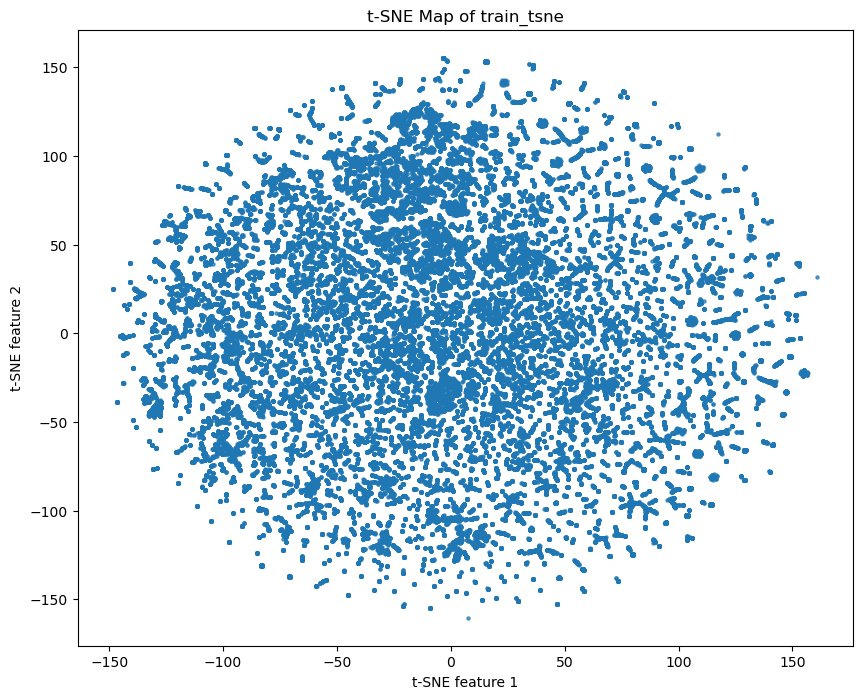

In [19]:
train_tsne_numeric = train_tsne.select_dtypes(include=[np.number])
# Инициализация t-SNE
tsne = TSNE(n_components=2, random_state=42)
# Применение t-SNE к данным
tsne_results = tsne.fit_transform(train_tsne_numeric)
# Создание scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Map of train_tsne")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

In [20]:
# Добавляем t-SNE данные в датасет
train_tsne['tSNE_f1'] = tsne_results[:, 0]
train_tsne['tSNE_f2'] = tsne_results[:, 1]

In [21]:
# Возвращаем target
train_tsne[['target']] = target_tsne[['target']]

In [22]:
train_tsne.to_csv(path + r'\train_tsne.csv', index=False)  # Можно потом переиспользовать

In [23]:
train_tsne = pd.read_csv(path + r'\train_tsne.csv')

In [24]:
# Фукция для изучения взамосвязей между переменными
def tSNE_feature(feature_name, train_tsne):
    """
    Создает scatter plot с градиентом цвета для указанной фичи из train_tsne.
    Parameters:
    - feature_name: str - Название столбца в train_tsne, используемого для градиента.
    - train_tsne: pd.DataFrame - DataFrame, содержащий данные t-SNE и фичу.
    Returns:
    - None
    """
    if feature_name not in train_tsne.columns:
        print(f"Предупреждение: столбец '{feature_name}' отсутствует в DataFrame train_tsne.")
        return
    
    # Нормализуем значения фичи для использования в альфа-канале
    feature_values = train_tsne[feature_name]
    normed_feature_values = (feature_values - feature_values.min()) / (feature_values.max() - feature_values.min())
    
    plt.figure(figsize=(10, 8))
    
    # Создаем scatter plot
    scatter = plt.scatter(
        train_tsne['tSNE_f1'],
        train_tsne['tSNE_f2'],
        c=feature_values,
        s=15,
        alpha=normed_feature_values,  # Прозрачность зависит от значения фичи
        cmap='coolwarm'  # Градиент от синего к красному
    )
    
    # Добавление цветовой шкалы
    plt.colorbar(scatter, label=f"{feature_name.capitalize()} Value")
    
    # Подписи
    plt.title(f"t-SNE Map of train_tsne with {feature_name.capitalize()} Gradient")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    
    # Показать график
    plt.show()

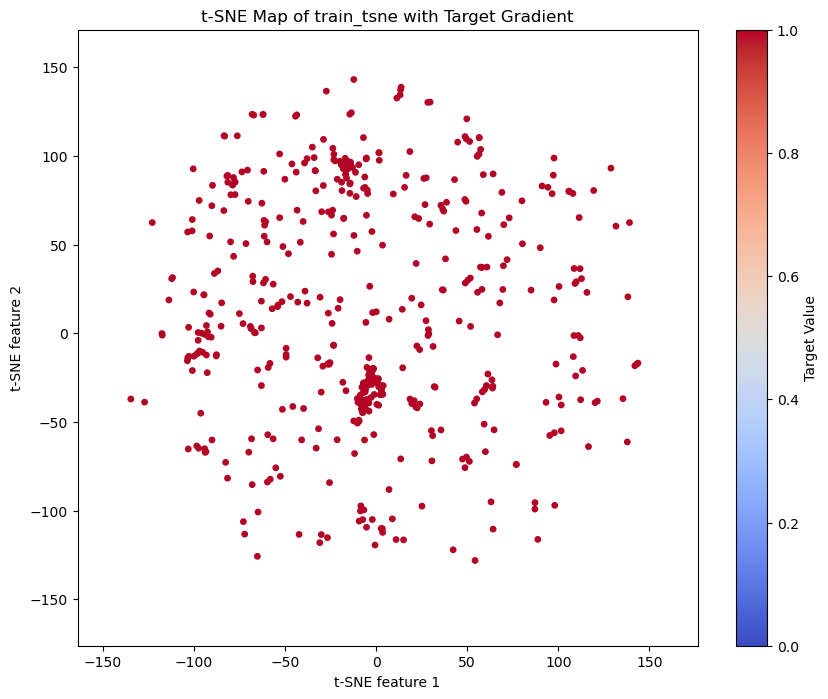

In [25]:
tSNE_feature('target', train_tsne)  # Собственно, успешный таргет

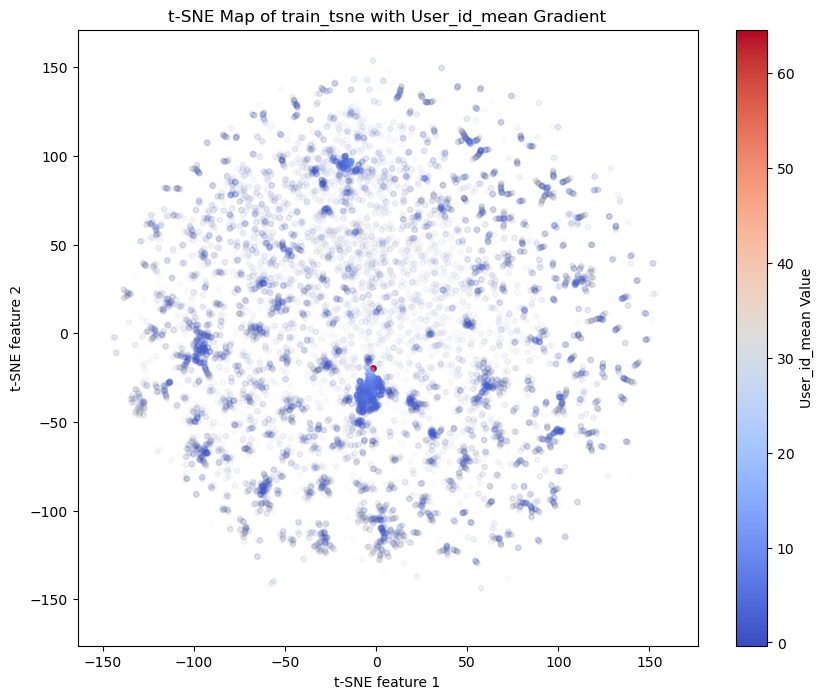

In [26]:
tSNE_feature('user_id_mean', train_tsne)  # Склонность клиента пользоваться скидкой

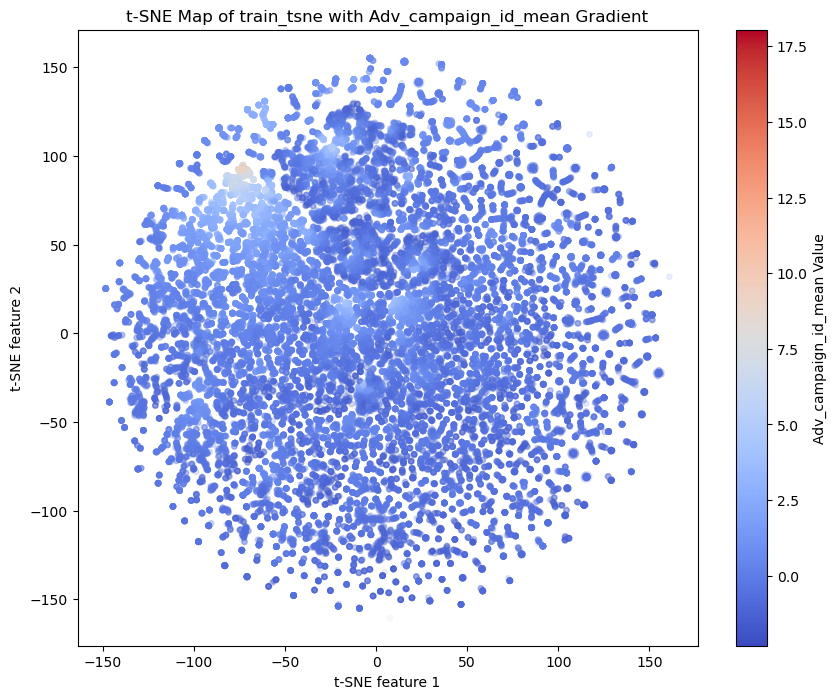

In [27]:
tSNE_feature('adv_campaign_id_mean', train_tsne)  # Привлекательность компании adv_campaign_id в плане "кликабельности"

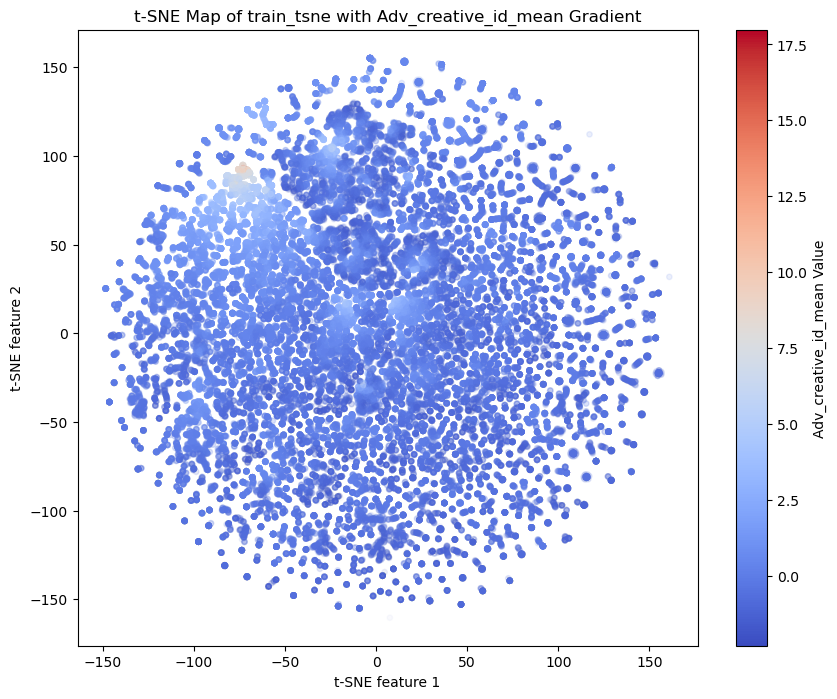

In [28]:
tSNE_feature('adv_creative_id_mean', train_tsne)  # Привлекательность креатива adv_creative_id в плане "кликабельности"

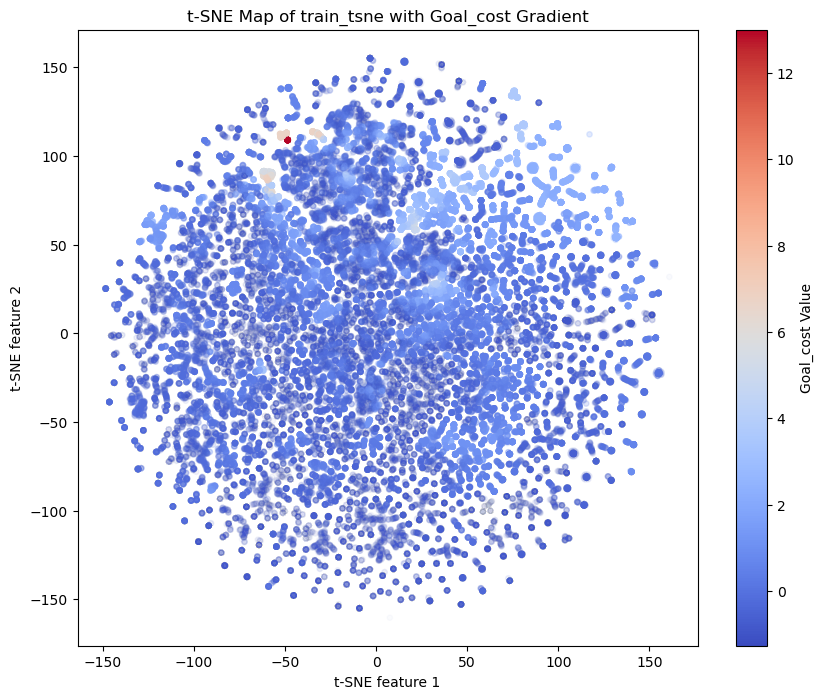

In [29]:
tSNE_feature('goal_cost', train_tsne)  # цена за клик на рекламу

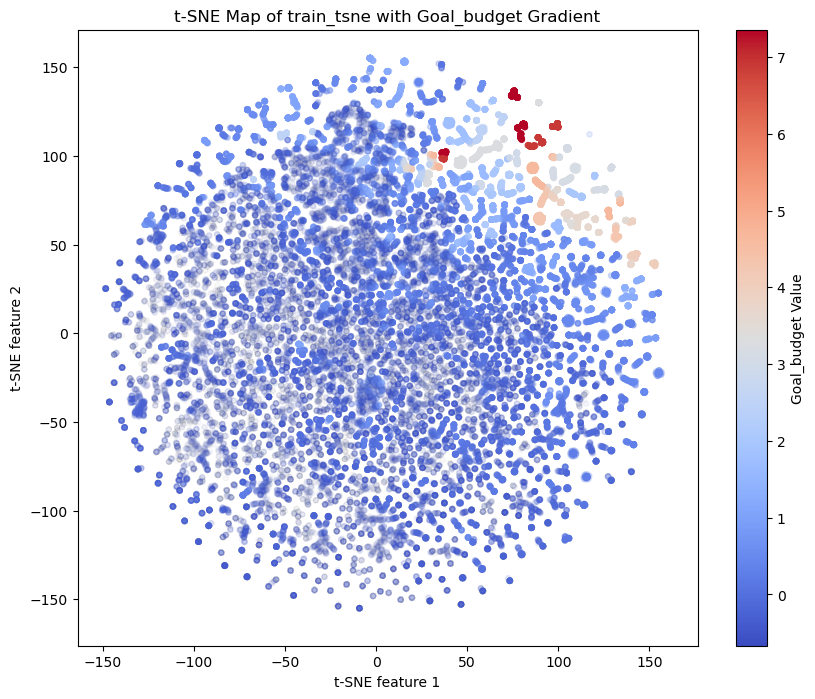

In [70]:
tSNE_feature('goal_budget', train_tsne) 

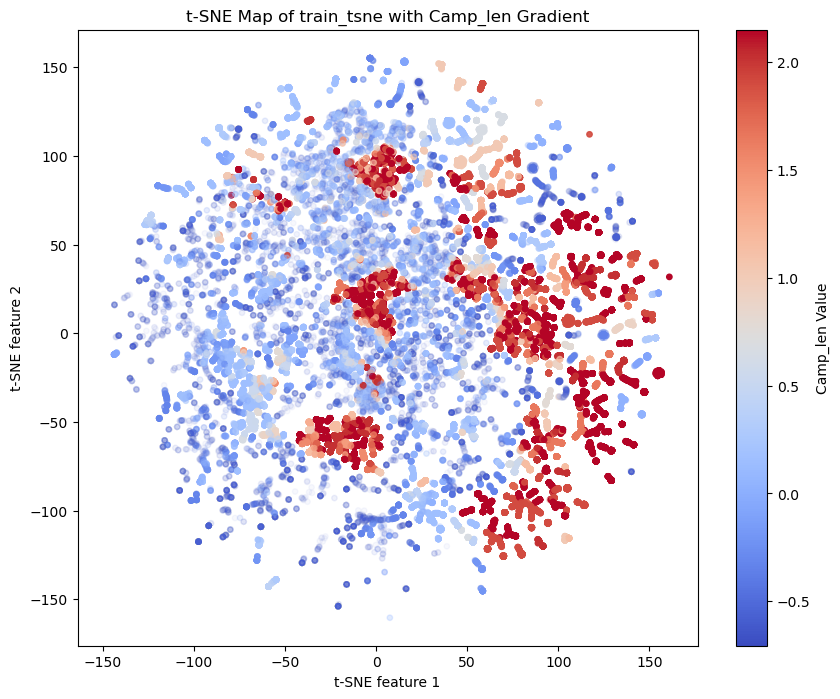

In [30]:
tSNE_feature('camp_len', train_tsne)  # Длина компании в днях

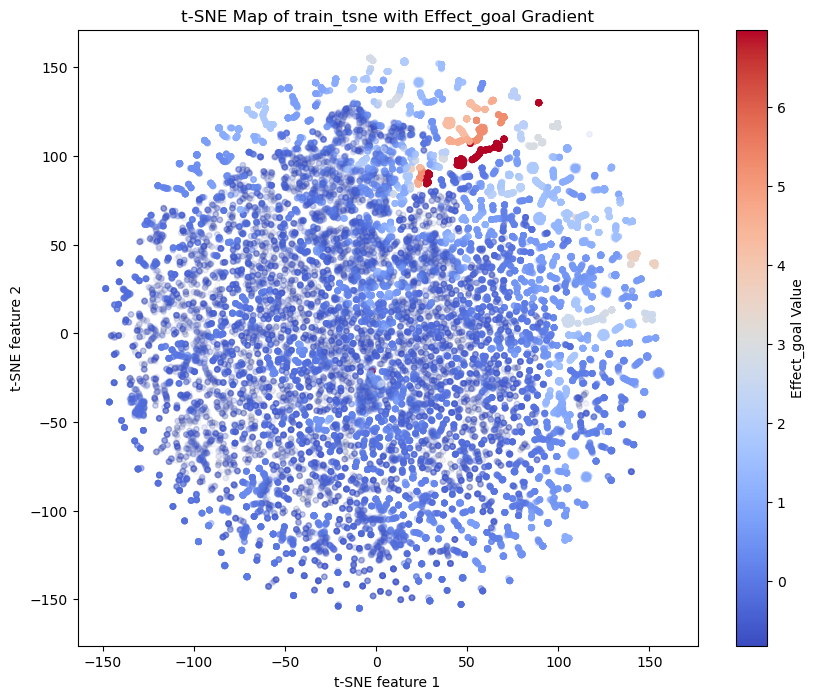

In [31]:
tSNE_feature('effect_goal', train_tsne)  # Сколько "кликов" заложено в бюджет компании

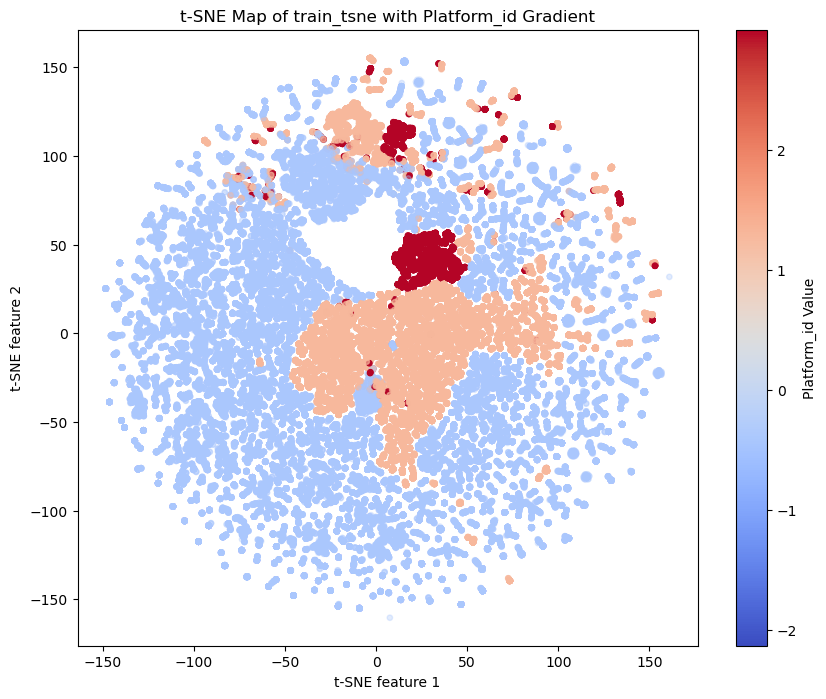

In [32]:
tSNE_feature('platform_id', train_tsne)

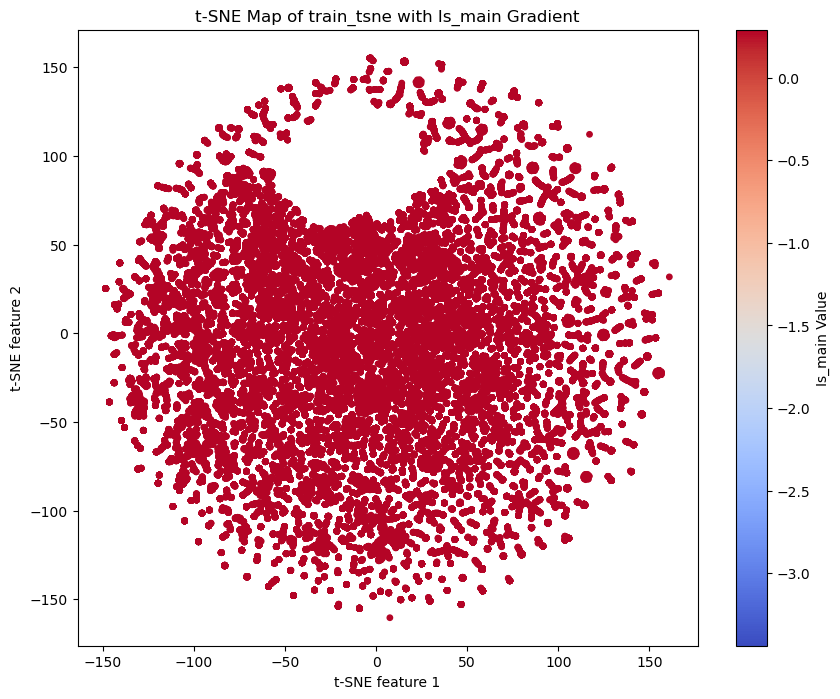

In [33]:
tSNE_feature('is_main', train_tsne)

In [ ]:
# Подготовка test к формированию простейшей модели

In [38]:
train.head(3)

user_id  adv_campaign_id  platform_id  adv_creative_id  banner_code  \
0  2853707             3352            3             3075            6   
1  2537244             4029            2             3260            8   
2    63033             1578            3             1109            6   

   is_main  target  user_id_mean  adv_campaign_id_mean  adv_creative_id_mean  \
0        1       0      0.064516              0.005920              0.005920   
1        1       0      0.015385              0.004265              0.004265   
2        1       0      0.025000              0.005667              0.005667   

   goal_cost  goal_budget  location_id  logcat_id  camp_len  effect_goal  
0   5.131051         2647            9         56         9          516  
1   4.931622         6953           46         65         6         1409  
2   3.711480         7035            1         65        14         1895

In [40]:
train.columns

Index(['user_id', 'adv_campaign_id', 'platform_id', 'adv_creative_id',
       'banner_code', 'is_main', 'target', 'user_id_mean',
       'adv_campaign_id_mean', 'adv_creative_id_mean', 'goal_cost',
       'goal_budget', 'location_id', 'logcat_id', 'camp_len', 'effect_goal'],
      dtype='object')

In [45]:
train['location_id'] = train['location_id'].astype('int16')
train['logcat_id'] = train['logcat_id'].astype('int16')

In [41]:
test.columns

Index(['user_id', 'adv_campaign_id', 'platform_id', 'adv_creative_id',
       'event_date', 'banner_code', 'is_main'],
      dtype='object')

In [47]:
test = test.drop(columns={'event_date'})

In [ ]:
# Перекодирование test

In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983287 entries, 0 to 1983286
Data columns (total 6 columns):
 #   Column           Dtype
---  ------           -----
 0   user_id          int64
 1   adv_campaign_id  int64
 2   platform_id      int64
 3   adv_creative_id  int64
 4   banner_code      int64
 5   is_main          bool 
dtypes: bool(1), int64(5)
memory usage: 77.5 MB


In [49]:
test['user_id'] = test['user_id'].astype('int32')
test['adv_campaign_id'] = test['adv_campaign_id'].astype('int16')
test['platform_id'] = test['platform_id'].astype('int8')
test['adv_creative_id'] = test['adv_creative_id'].astype('int16')
test['banner_code'] = test['banner_code'].astype('int8')
test['is_main'] = test['is_main'].astype('int8')

In [ ]:
# Формирование фич в test

In [50]:
test.columns

Index(['user_id', 'adv_campaign_id', 'platform_id', 'adv_creative_id',
       'banner_code', 'is_main'],
      dtype='object')

In [51]:
# Перенос фичи 'user_id_mean'
user_id_to_mean = dict(zip(train['user_id'], train['user_id_mean']))
test['user_id_mean'] = test['user_id'].map(user_id_to_mean).fillna(0).astype(np.float32)

In [64]:
# Перенос фичи 'adv_campaign_id_mean', ''
counts = train.groupby('adv_campaign_id', as_index=False).agg({
    'adv_campaign_id_mean': 'first'
})

test = test.merge(
    counts,  # выбираем только нужные колонки из simple
    on='adv_campaign_id',  # объединяем по user_id
    how='left'  # используем left join, чтобы сохранить все строки из test
)

In [66]:
# Перенос фичи 'adv_creative_id_mean'
counts = train.groupby('adv_creative_id', as_index=False).agg({
    'adv_creative_id_mean': 'first'
})

test = test.merge(
    counts,  # выбираем только нужные колонки из simple
    on='adv_creative_id',  # объединяем по user_id
    how='left'  # используем left join, чтобы сохранить все строки из test
)

In [68]:
# Перенос фичи 'goal_cost'
counts = camps.groupby('adv_campaign_id', as_index=False).agg({
    'goal_cost': 'first'
})

test = test.merge(
    counts,  # выбираем только нужные колонки из simple
    on='adv_campaign_id',  # объединяем по user_id
    how='left'  # используем left join, чтобы сохранить все строки из test
)

In [71]:
# Перенос фичи 'goal_budget'
counts = camps.groupby('adv_campaign_id', as_index=False).agg({
    'goal_budget': 'first'
})

test = test.merge(
    counts,  # выбираем только нужные колонки из simple
    on='adv_campaign_id',  # объединяем по user_id
    how='left'  # используем left join, чтобы сохранить все строки из test
)

In [75]:
# Перенос фич 'location_id', 'logcat_id', 'camp_len', 'effect_goal'
counts = camps.groupby('adv_campaign_id', as_index=False).agg({
    'location_id': 'first',
    'logcat_id': 'first',
    'camp_len': 'first',
    'effect_goal': 'first'
})

test = test.merge(
    counts,  # выбираем только нужные колонки из simple
    on='adv_campaign_id',  # объединяем по user_id
    how='left'  # используем left join, чтобы сохранить все строки из test
)

In [77]:
test['location_id'] = test['location_id'].astype('int16')
test['logcat_id'] = test['logcat_id'].astype('int16')

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   user_id               int32  
 1   adv_campaign_id       int16  
 2   platform_id           int8   
 3   adv_creative_id       int16  
 4   banner_code           int8   
 5   is_main               int8   
 6   target                int8   
 7   user_id_mean          float32
 8   adv_campaign_id_mean  float32
 9   adv_creative_id_mean  float32
 10  goal_cost             float32
 11  goal_budget           int32  
 12  location_id           int16  
 13  logcat_id             int16  
 14  camp_len              int16  
 15  effect_goal           int32  
dtypes: float32(4), int16(5), int32(3), int8(4)
memory usage: 4.5 GB


In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983287 entries, 0 to 1983286
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   user_id               int32  
 1   adv_campaign_id       int16  
 2   platform_id           int8   
 3   adv_creative_id       int16  
 4   banner_code           int8   
 5   is_main               int8   
 6   user_id_mean          float32
 7   adv_campaign_id_mean  float32
 8   adv_creative_id_mean  float32
 9   goal_cost             float32
 10  goal_budget           int32  
 11  location_id           int16  
 12  logcat_id             int16  
 13  camp_len              int16  
 14  effect_goal           int32  
dtypes: float32(4), int16(5), int32(3), int8(3)
memory usage: 77.5 MB


In [82]:
# Сохраняем на диск
train.to_parquet(path + r'\train_features.parquet', index=False)
test.to_csv(path + r'\test_features.csv', index=False)